In [1]:
!pip install keras-facenet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
from os import listdir
from PIL import Image as Img
from numpy import asarray
from numpy import expand_dims
from matplotlib import pyplot
from keras.models import load_model
import numpy as np
import tensorflow as tf
import pickle
import cv2
from keras_facenet import FaceNet

In [3]:
HaarCascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [4]:
MyFaceNet = FaceNet()

In [5]:
folder='trainFoto/'
database = {}
for filename in listdir(folder):
  if filename != '.ipynb_checkpoints':
    path = folder + filename
    gbr1 = cv2.imread(folder + filename)

    wajah = HaarCascade.detectMultiScale(gbr1,1.1,4)

    if len(wajah)>0:
        x1, y1, width, height = wajah[0]         
    else:
        x1, y1, width, height = 1, 1, 10, 10

    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height

    gbr = cv2.cvtColor(gbr1, cv2.COLOR_BGR2RGB)
    gbr = Img.fromarray(gbr)              
    gbr_array = asarray(gbr)

    face = gbr_array[y1:y2, x1:x2]                        

    face = Img.fromarray(face)                       
    face = face.resize((160,160))
    face = asarray(face)

    face = expand_dims(face, axis=0)
    signature = MyFaceNet.embeddings(face)

    database[os.path.splitext(filename)[0]]=signature

1/1 [==============================] - 0s 96ms/step


In [6]:
myfile = open("data.pkl", "wb")
pickle.dump(database, myfile)
myfile.close()

In [7]:
myfile = open("data.pkl", "rb")
database = pickle.load(myfile)
myfile.close()

In [8]:
def js_to_image(js_reply):
  image_bytes = b64decode(js_reply.split(',')[1])
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  img = cv2.imdecode(jpg_as_np, flags=1)
  return img

In [13]:
def findFaces(data):
  gbr1 = js_to_image(data)
  gbr = cv2.cvtColor(gbr1, cv2.COLOR_BGR2RGB)
  gbr = Img.fromarray(gbr)               
  gbr_array = asarray(gbr)
 
  wajah = HaarCascade.detectMultiScale(gbr1,1.1,4)
  
  for (x1,y1,w,h) in wajah:
      x1, y1 = abs(x1), abs(y1)
      x2, y2 = x1 + w, y1 + h
    
      face = gbr_array[y1:y2, x1:x2]                        
    
      face = Img.fromarray(face)                       
      face = face.resize((160,160))
      face = asarray(face)
        
      face = expand_dims(face, axis=0)
      signature = MyFaceNet.embeddings(face)
    
      min_dist=100
      identity=' '
      for key, value in database.items() :
        dist = np.linalg.norm(value-signature)
        if dist < min_dist:
          min_dist = dist
          identity = key
            
      cv2.putText(gbr1,identity, (x1,y1),cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 0), 2, cv2.LINE_AA)
      cv2.rectangle(gbr1,(x1,y1),(x2,y2), (0,255,0), 2)
  
  filename='photo.jpg'
  cv2.imwrite(filename, gbr1)
  
  return filename  

In [14]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  filename=findFaces(data)
  return filename

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 65ms/step
Saved to photo.jpg


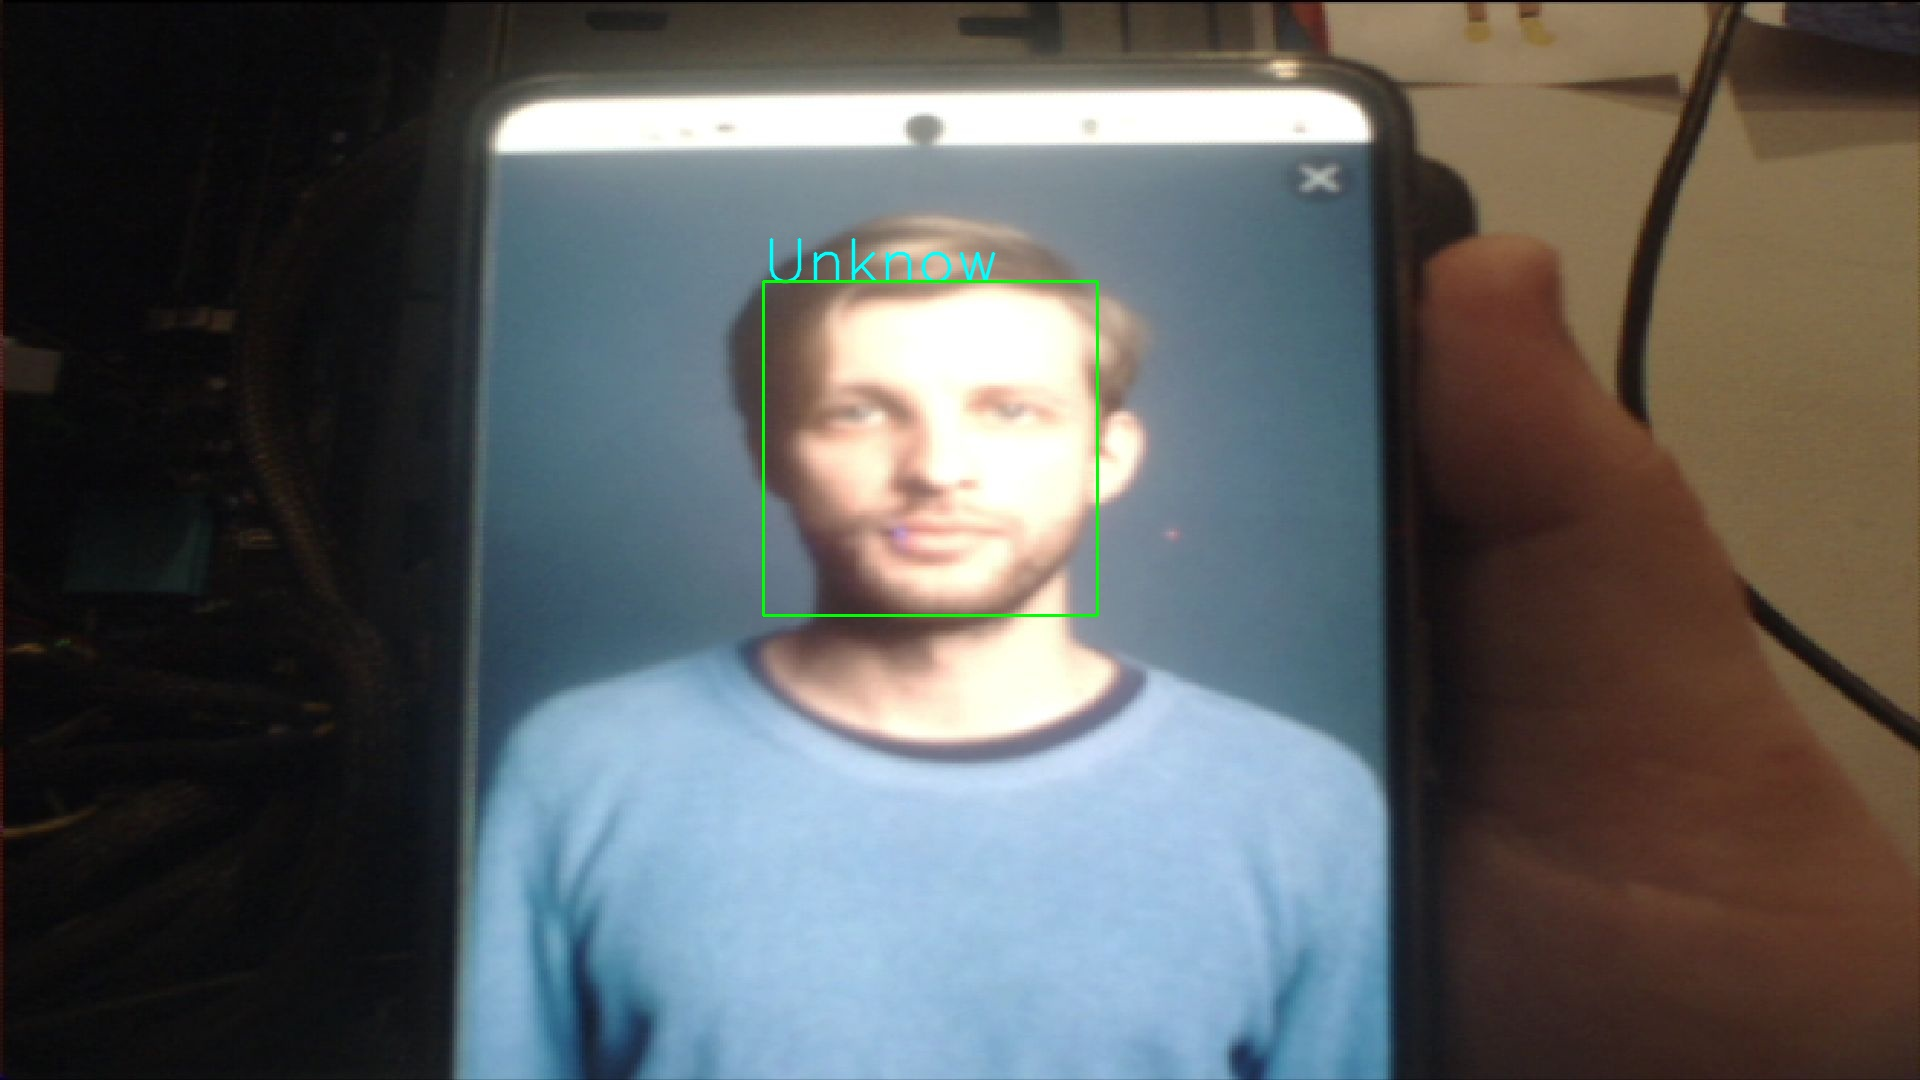

In [20]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  display(Image(filename))
except Exception as err:
  print(str(err))